<div style="background-color: #424449; padding: 30px; text-align: center; font-size: 36px; font-weight: bold;">
  <span style="color: #caccd1;">2. Pré Processamento</span>
</div>

In [1]:
%%capture
%run 1.Analise_Exploratoria_ts.ipynb

Aqui vamos remover uma certa seção dos dados, mais precisamente observações de 1940 a 1964. O motivo são dados muito antigos e que podem induzir ruídos desnecessários.

In [2]:
# Cópia do DataFrame
df2 = df.copy()

In [3]:
# Selecionar as linhas com índices após 1965
split_date = '1965-01-01'
df2 = df2.loc[df2.index >= split_date]

In [4]:
# Tamanho do Dataframe após a remoção de uma parte da série temporal
df2.shape

(696, 1)

In [5]:
df2.head()

,producao
data,
1965-01-01,29.4926
1965-02-01,28.8310
1965-03-01,28.8819
1965-04-01,28.2203
1965-05-01,27.7368


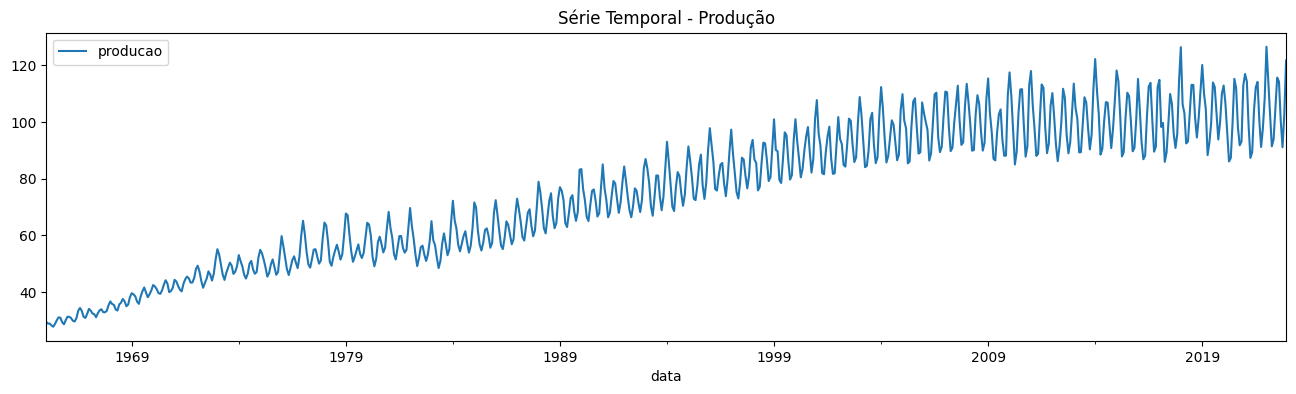

In [6]:
# Gráfico da série temporal após o corte nos dados
df2.plot(figsize=(16,4),legend=True)

plt.title('Série Temporal - Produção')

plt.show();

In [7]:
# Separação dos dados de treino e teste, com o teste contendo os últimos 12 meses
train_ari = df2[:-12]
test_ari = df2[-12:]

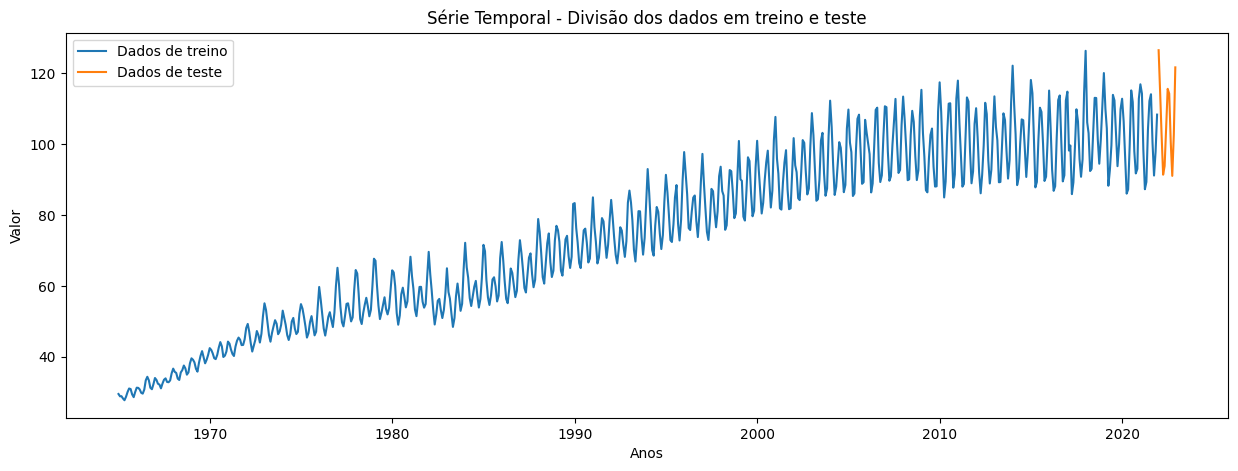

In [8]:
# Gráfico da divisão dos dados em treino e teste
plt.figure(figsize=(15,5))
plt.plot(train_ari, label="Dados de treino")
plt.plot(test_ari, label="Dados de teste")
plt.legend(loc="best")
plt.xlabel("Anos")
plt.ylabel("Valor")
plt.title("Série Temporal - Divisão dos dados em treino e teste")
plt.show();

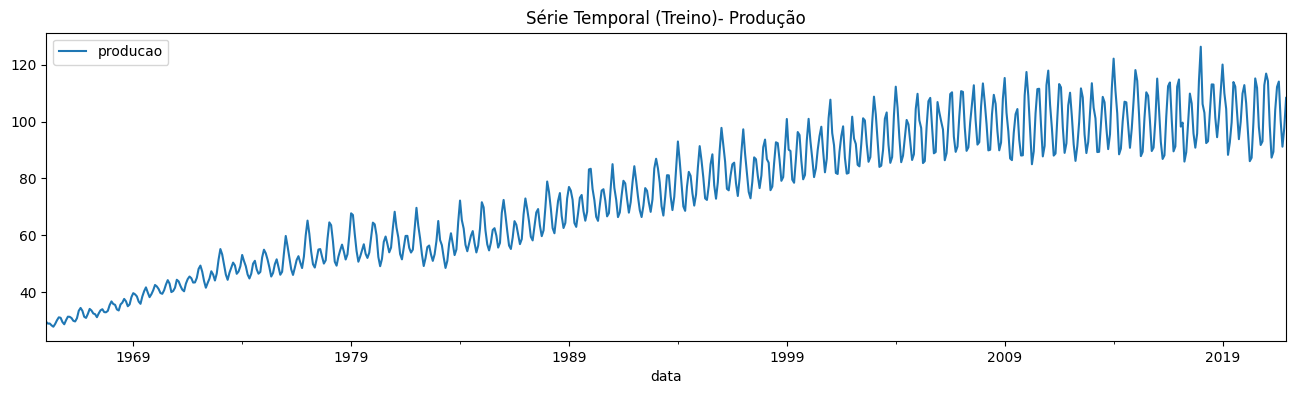

In [9]:
# Gráfico da série temporal para os dados de treino
train_ari.plot(figsize=(16,4),legend=True)

plt.title('Série Temporal (Treino)- Produção')

plt.show();

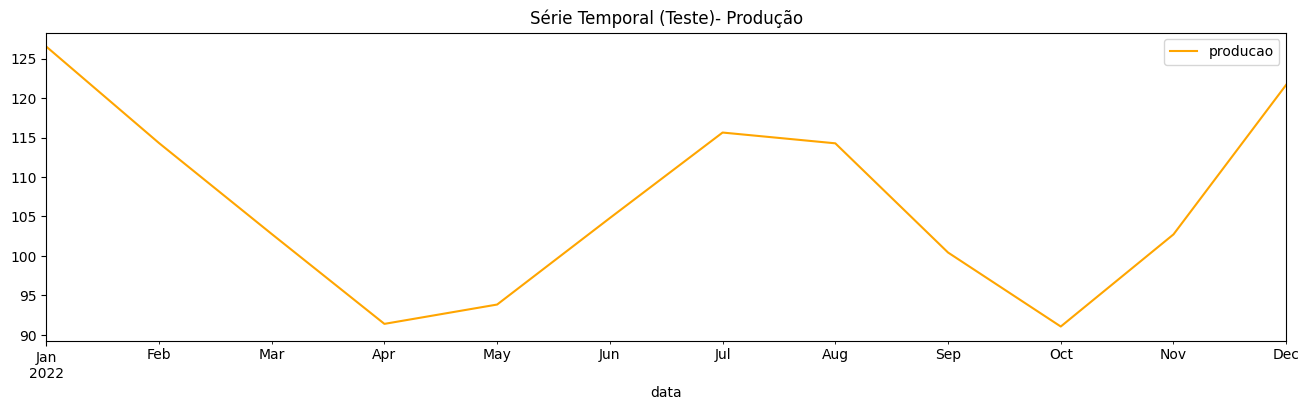

In [10]:
# Gráfico da série temporal para os dados de teste
test_ari.plot(figsize=(16,4),legend=True, color='orange')

plt.title('Série Temporal (Teste)- Produção')

plt.show();

Vamos verificar se após o corte nos dados a série temporal continua não estacionária.

In [11]:
# Teste de Augmented Dickey-Fuller para os dados de treino
adfuller_test(train_ari['producao'])

Teste ADF: p-valor = 0.15835446094420064
A série temporal NÃO é estacionária


In [12]:
# Teste KPSS para os dados de treino
kpss_test(train_ari['producao'])

Results of KPSS Test:
Test Statistic            4.06203
p-value                   0.01000
Lags Used                16.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64
A série temporal NÃO é estacionária


Assim, constata-se que a série temporal mantém-se não estacionária.

Deste modo, se a série não for estacionária, é possível aplicar uma diferenciação para torná-la estacionária, ou seja, com média e variância constantes ao longo do tempo. A diferenciação consiste em calcular a diferença entre os valores da série em diferentes momentos no tempo, a primeira diferença é calculada subtraindo o valor de uma observação no tempo t pelo valor da observação no tempo t-1, a segunda diferença é calculada subtraindo o valor da primeira diferença no tempo t pelo valor da primeira diferença no tempo t-1, e assim por diante. A ordem de diferenciação, ou "d", refere-se ao número de vezes que a diferença é calculada. Essa técnica é útil porque muitos modelos estatísticos pressupõem que a série seja estacionária, e séries não estacionárias podem gerar resultados incorretos. Além disso, a diferenciação pode ajudar a remover tendências de longo prazo e tornar os dados mais fáceis de interpretar. A série resultante é chamada de série diferenciada e, se for estacionária, pode ser modelada com o modelo ARIMA.

**1 Diferenciação**

In [13]:
# Criando uma nova série temporal com a diferença
dif_df1 = train_ari.diff(1)
dif_df1.head()

,producao
data,
1965-01-01,NaN
1965-02-01,-0.6616
1965-03-01,0.0509
1965-04-01,-0.6616
1965-05-01,-0.4835


In [14]:
# Remove o primeiro valor devido a diferença 
dif_df1 = dif_df1.dropna()
dif_df1.head()

,producao
data,
1965-02-01,-0.6616
1965-03-01,0.0509
1965-04-01,-0.6616
1965-05-01,-0.4835
1965-06-01,0.9924


OBS: os valores negativos após a diferenciação indicam que a produção de eletricidade diminuiu em relação ao mês anterior.

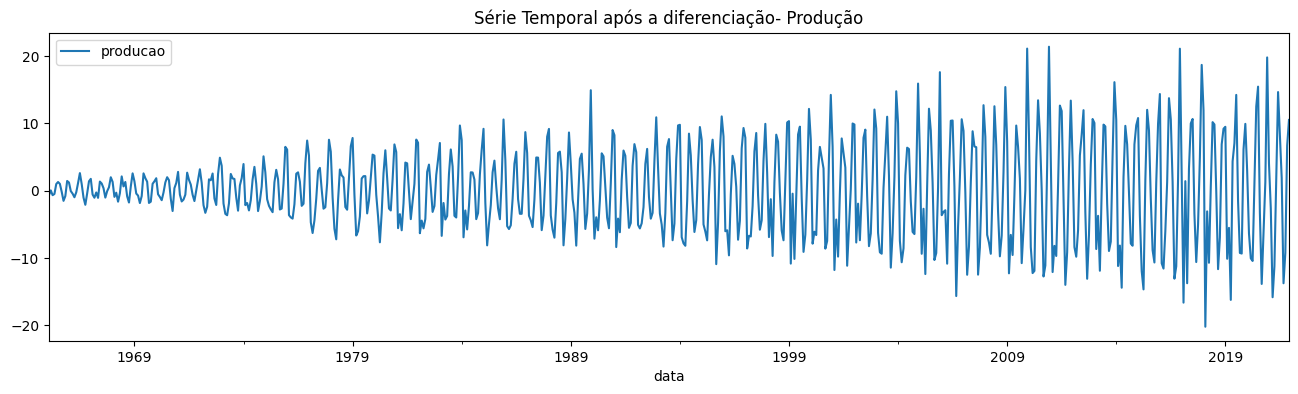

In [15]:
# Gráfico da série temporal diferenciada 1 vez
dif_df1.plot(figsize=(16,4),legend=True)

plt.title('Série Temporal após a diferenciação- Produção')

plt.show();

Podemos perceber através dos gráficos que a série temporal não apresenta mais uma forte tendência após a diferenciação.

Vamos aplicar os testes para verificar se com a diferenciação a série temporal tornou-se estacionária.

In [16]:
# Teste Augmented Dickey-Fuller após a primeira diferenciação
adfuller_test(dif_df1['producao'])

Teste ADF: p-valor = 4.962151531396951e-15
A série temporal é estacionária


In [17]:
# Teste KPSS após a primeira diferenciação
kpss_test(dif_df1['producao'])

Results of KPSS Test:
Test Statistic            0.037433
p-value                   0.100000
Lags Used                33.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
A série temporal é estacionária


Se após a aplicação da primeira diferenciação a série temporal se tornar estacionária, não há necessidade de aplicar uma segunda diferenciação. A ideia da diferenciação é remover tendências e sazonalidades da série temporal para torná-la estacionária, de modo que a aplicação de mais diferenciações pode ser desnecessária e até mesmo prejudicar a análise da série.

Assim, apenas uma diferenciação foi suficiente para tornar a série temporal em estacionária. Entretanto, mediante os gráficos é possível identificar uma sazonalidade significativa e que não pode ser ignorada. Diante disso, além de realizar a diferenciação também é necessário realizar a diferenciação sazonal.

Uma maneira comum de remover a componente sazonal de uma série temporal é por meio da diferenciação sazonal, que envolve a subtração da série de sua própria sazonalidade. Isso geralmente é feito por meio de uma diferença sazonal, ou seja, a diferença entre a série original e a série deslocada por um número fixo de períodos sazonais. A diferença sazonal ajuda a remover a sazonalidade da série temporal, tornando-a mais fácil de modelar.

**1 diferenciação e 1 diferenciação sazonal**

In [18]:
# Aplica a diferenciação sazonal
seasonal_diff = train_ari.diff(1).diff(12)
seasonal_diff.head(15)

,producao
data,
1965-01-01,NaN
1965-02-01,NaN
1965-03-01,NaN
1965-04-01,NaN
1965-05-01,NaN
1965-06-01,NaN
1965-07-01,NaN
1965-08-01,NaN
1965-09-01,NaN


In [19]:
# Remove os valores nulos resultantes da diferenciação
seasonal_diff = seasonal_diff.dropna()
seasonal_diff.head()

,producao
data,
1966-02-01,0.6107
1966-03-01,-0.4835
1966-04-01,-0.3054
1966-05-01,0.2545
1966-06-01,0.1527


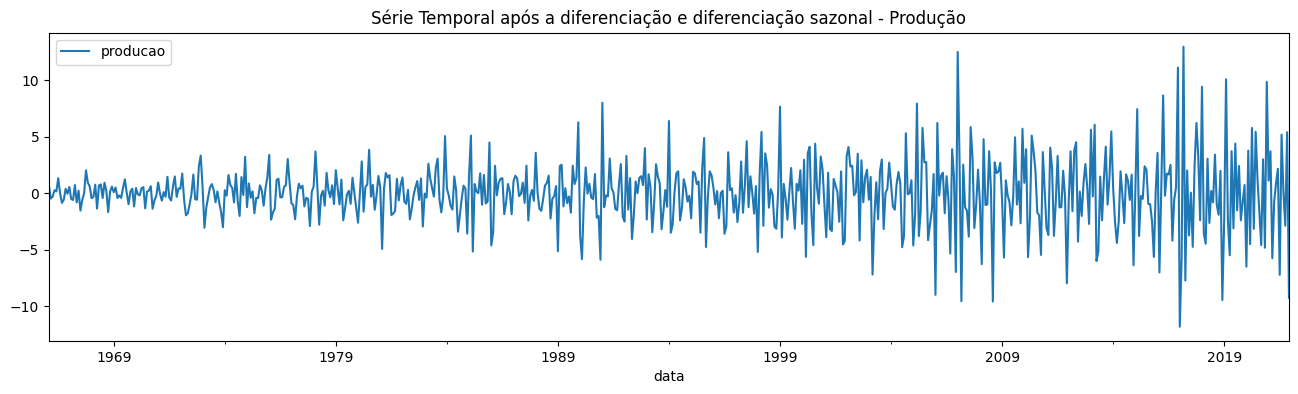

In [20]:
# Gráfico da série temporal com 1 diferenciação e 1 diferenciação sazonal
seasonal_diff.plot(figsize=(16,4),legend=True)

plt.title('Série Temporal após a diferenciação e diferenciação sazonal - Produção')

plt.show();

Após a diferenciação e a diferenciação sazonal a série temporal continua sem apresentar uma tendência.

Aplicaremos os testes mais uma vez:

In [21]:
# Teste Augmented Dickey-Fuller
adfuller_test(seasonal_diff['producao'])

Teste ADF: p-valor = 3.5289642605380746e-15
A série temporal é estacionária


In [22]:
# Teste KPSS
kpss_test(seasonal_diff['producao'])

Results of KPSS Test:
Test Statistic            0.053853
p-value                   0.100000
Lags Used                35.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
A série temporal é estacionária


Com a diferença sazonal a série temporal também torna-se estacionária.

Como foi necessário aplicar somente 1 diferenciação e 1 diferenciação sazonal, os valores dos componentes d e D são ambos iguais a 1.

Uma vez que encontramos os valores de d e D, agora precisamos encontrar os termos AR (AutoRegressive) e MA (Moving Average), além dos termos SAR (Seasonal AutoRegressive) e SMA (Seasonal Moving Average) para o modelo ARIMA (AutoRegressive Integrated Moving Average). Para isso vamos utilizar os gráficos ACF (Autocorrelation Function) e PACF (Partial Autocorrelation Function). 

O gráfico ACF mostra a autocorrelação em diferentes lags, enquanto o gráfico PACF mostra a autocorrelação parcial após controlar os efeitos dos lags intermediários.

Lags em séries temporais referem-se a atrasos no tempo que são usados para comparar uma observação atual com as observações anteriores. Esses atrasos são importantes na análise de séries temporais, porque eles podem ajudar a identificar padrões sazonais e tendências em dados ao longo do tempo.


**Gráficos ACF e PACF**

Para estimar quantos termos AR devem ser usados, é preciso contar quantos “pirulitos” estão acima ou abaixo do intervalo de confiança antes que o próximo entre na área azul no gráfico PACF.

Enquanto para estimar a quantidade de termos MA, desta vez é necessário analisar o gráfico ACF e aplicar a mesma lógica de contar quantos pirulitos estão acima ou abaixo do intervalo de confiança antes que o próximo pirulito entre na área azul.

Como a série temporal possui sazonalidade é preciso também identificar os termos SAR, I e SMA.

Para o termo I a mesma lógica de estimar diferenças não sazonais é aplicada. Se foi utilizada a diferenciação sazonal para tornar a série temporal estacionária (por exemplo, o valor real (Yt) subtraído por 12 meses anteriores (Yt-12), é necessário adicionar 1 termo à diferenciação sazonal.

Para estimar a quantidade de termos SAR é preciso verificar mais uma vez o gráfico PACF. Agora, em vez de contar quantos pirulitos estão fora do intervalo de confiança, é preciso contar quantos pirulitos sazonais estão fora. Por exemplo, se os dados foram coletados mensalmente e tem uma sazonalidade anual, verifica-se se o “pirulito” no lag 12 está fora da área do intervalo de confiança. Em caso de resultado positivo, é necessário adicionar 1 termo para o SAR.

Para a média móvel sazonal (SMA), veremos o gráfico ACF e usaremos a mesma lógica de estimativa dos termos SAR.

Referência: https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html

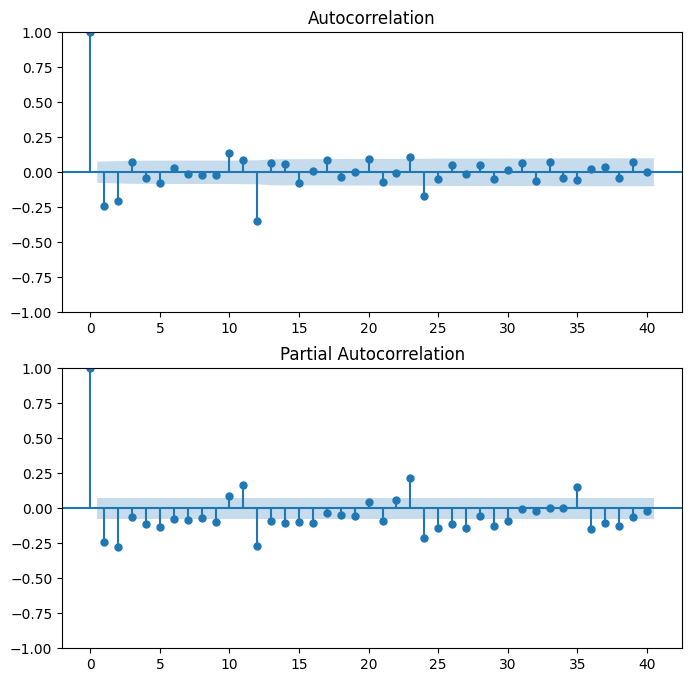

In [23]:
# Gráficos ACF e PACF
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(8,8))

plot_acf(seasonal_diff,lags=40, zero=True, ax=ax1)
plot_pacf(seasonal_diff,lags=40, zero=True, ax=ax2)
plt.show();

Assim, por meio da análise dos gráficos podemos concluir que:

p = 2

d = 1

q = 2

P = 2

D = 1

Q = 2

São escolhas razoáveis baseadas nas análises feitas.